<a href="https://colab.research.google.com/github/Fnriquel/281-Project/blob/main/Efficiennet_Colabversion_normalized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import charset_normalizer
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, GlobalMaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Adamax, SGD, Adagrad
from sklearn.model_selection import train_test_split

In [3]:
source_dir = "/content/drive/MyDrive/W281/Original"
train_dir = "/content/drive/MyDrive/W281/Train_image"
test_dir = "/content/drive/MyDrive/W281/Test_image"

In [4]:
## function to do Adaptive histogram equalization
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

def min_max_intensity_normalization(img):
    img_array = img_to_array(img)
    min_value = np.min(img_array)
    max_value = np.max(img_array)
    normalized_array = (img_array - min_value) / (max_value - min_value)
    return normalized_array

def adaptive_hist_eq(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(image)
    return cl1

## function to do histogram normalization
from skimage import exposure, color

def hist_norm(img):
    img[:,:,0] = exposure.equalize_hist(img[:,:,0])
    img[:,:,1] = exposure.equalize_hist(img[:,:,1])
    img[:,:,2] = exposure.equalize_hist(img[:,:,2])
    return img

##function that gets all the pictures from the directory and apply the adaptive histogram equalization
def get_images_processing(directory, processing='adaptive_histogram_equalization'):
    images=[]
    for dir in os.listdir(directory):
        for dir1 in os.listdir('Original'+'\\'+str(dir)):
            img = cv2.imread(directory+'\\'+dir+'\\'+dir1)
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            if processing == 'adaptive_histogram_equalization':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = adaptive_hist_eq(img)
            elif processing == 'histogram_normalization':
                img = hist_norm(img)   
            elif processing == 'sharpening':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
                img = cv2.filter2D(img, -1, kernel)
            else:
                img = img
            
            images.append(img)
    return images

Only run the cell bellow to create the 2 folders Train and Test.

In [ ]:
import shutil
import random



# Create train and test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Set the percentage of images to use for training
train_percentage = 0.8

# Loop through each sub-directory in the source directory
for subdir in os.listdir(source_dir):
    subdir_path = os.path.join(source_dir, subdir)
    
    # Create train and test sub-directories
    os.makedirs(os.path.join(train_dir, subdir), exist_ok=True)
    os.makedirs(os.path.join(test_dir, subdir), exist_ok=True)
    
    # Split the images between train and test sets
    images = os.listdir(subdir_path)
    random.shuffle(images)
    split_index = int(train_percentage * len(images))
    train_images = images[:split_index]
    test_images = images[split_index:]
    
    # Copy the train images to the train directory
    for image in train_images:
        source = os.path.join(subdir_path, image)
        destination = os.path.join(train_dir, subdir, image)
        shutil.copy(source, destination)
    
    # Copy the test images to the test directory
    for image in test_images:
        source = os.path.join(subdir_path, image)
        destination = os.path.join(test_dir, subdir, image)
        shutil.copy(source, destination)

In [7]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
img_size = (224, 224)
input_shape = (224,224,3)


# Create a base model from the pre-trained 
#base_model = EfficientNetB3(input_shape=input_shape, include_top=False, weights='imagenet') 
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2L(input_shape=input_shape, include_top=False)
# Make model trainable
base_model.trainable = True
inputs=keras.Input(shape=input_shape)
x = base_model(inputs)
#x = base_model.output
x = GlobalMaxPool2D()(x)
x = Dropout(0.1)(x)
#x = BatchNormalization()(x)

outputs = Dense(4, activation='softmax')(x)
model = Model(inputs, outputs)
fine_tune_at = 1 # Update parameters starting from layer 1
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = True

In [8]:
from sklearn.utils.class_weight import compute_class_weight


img_size = (224, 224)
color_mode = 'rgb'
datagen = ImageDataGenerator(preprocessing_function=min_max_intensity_normalization,rescale=1./255, validation_split=0.25)

train_generator = datagen.flow_from_directory(
    "/content/drive/MyDrive/W281/Train_image",
    target_size=img_size,
    batch_size=16,
    class_mode='categorical',
    subset='training')




val_generator = datagen.flow_from_directory(
        "/content/drive/MyDrive/W281/Train_image",
        target_size=img_size,
        batch_size=16,
        class_mode='categorical',
        subset='validation')

labels = train_generator.labels
print(labels)
class_labels = np.unique(labels)
print(class_labels)
# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(labels), y=labels)

# Convert to dictionary
class_weights_dict = dict(enumerate(class_weights))


print(class_weights_dict)

Found 1955 images belonging to 4 classes.
Found 649 images belonging to 4 classes.
[0 0 0 ... 3 3 3]
[0 1 2 3]
{0: 1.613036303630363, 1: 0.8269881556683587, 2: 0.8455882352941176, 3: 1.0119047619047619}


In [9]:
loss = 'categorical_crossentropy' # Better performance than categorical_crossentropy
# optimizer = keras.optimizers.Adam
optimizer = Adamax

# Create learning rates for two phases of training 
learning_rates = 0.001

# Setting the number of training epochs
training_epochs = 5

metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalAccuracy(name='accuracy'), # Use CategoricalAccuracy for one-hot encoded labels
      #keras.metrics.SparseCategoricalAccuracy(name='accuracy'), # Use SparseCategoricalAccuracy for integer labels
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'), 
      keras.metrics.SpecificityAtSensitivity(0.5,name='SpecificityAtSensitivity'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model.compile(loss=loss, optimizer=optimizer(learning_rates), metrics=metrics)






In [10]:
history = model.fit(
    train_generator,
    epochs=training_epochs,
    validation_data=val_generator,
    class_weight=class_weights_dict 
)



Epoch 1/5
123/123 [==============================] - 313s 965ms/step - loss: 1.7408 - tp: 112.0000 - fp: 311.0000 - tn: 5554.0000 - fn: 1843.0000 - accuracy: 0.2348 - precision: 0.2648 - recall: 0.0573 - SpecificityAtSensitivity: 0.4697 - auc: 0.4981 - prc: 0.2482 - val_loss: 1.3859 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1947.0000 - val_fn: 649.0000 - val_accuracy: 0.2958 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_SpecificityAtSensitivity: 0.5141 - val_auc: 0.5137 - val_prc: 0.2731
Epoch 2/5
123/123 [==============================] - 110s 890ms/step - loss: 1.4045 - tp: 1.0000 - fp: 1.0000 - tn: 5864.0000 - fn: 1954.0000 - accuracy: 0.2343 - precision: 0.5000 - recall: 5.1151e-04 - SpecificityAtSensitivity: 0.4731 - auc: 0.5000 - prc: 0.2470 - val_loss: 1.4226 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1947.0000 - val_fn: 649.0000 - val_accuracy: 0.1541 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_SpecificityAtSensitivity: 0.2322 - va

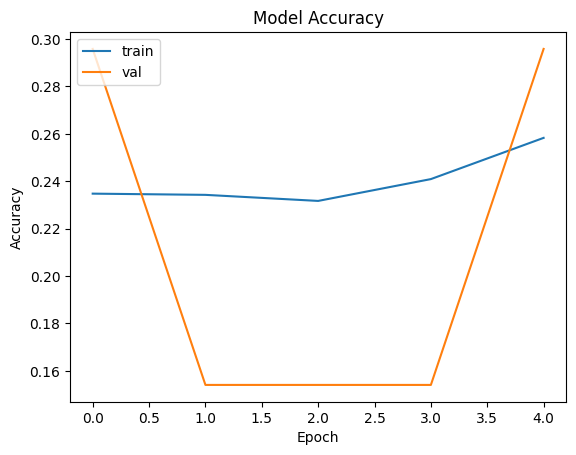

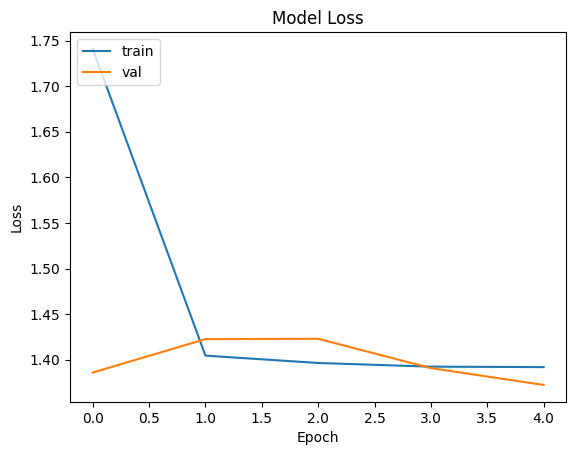

In [11]:

# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
# Evaluate on test set
from sklearn.metrics import f1_score
datagen = ImageDataGenerator(rescale=1./255)

test_data = datagen.flow_from_directory(
    "/content/drive/MyDrive/W281/Test_image",
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    )
test_results = model.evaluate(test_data, verbose=2)
tp = test_results[1]
fp = test_results[2]
tn = test_results[3]
fn = test_results[4]
accuracy=test_results[5]
precision=test_results[6]
recall=test_results[7]


Found 652 images belonging to 4 classes.
21/21 - 10s - loss: 1.3868 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1956.0000 - fn: 652.0000 - accuracy: 0.3083 - precision: 0.0000e+00 - recall: 0.0000e+00 - SpecificityAtSensitivity: 0.4632 - auc: 0.5211 - prc: 0.3591 - 10s/epoch - 499ms/step


In [16]:
import numpy as np

# Get the number of batches in the test_data
num_batches = len(test_data)

# Initialize an empty list to store images
images_list = []
labels_list= []

# Loop through the test_data generator
for i in range(num_batches):
    # Get a batch of images and their labels
    images_batch, labels_batch = next(test_data)
    
    # Append the images from this batch to the images_list
    images_list.append(images_batch)
    labels_list.append(labels_batch)

# Concatenate all the batches into a single numpy array
images_array = np.concatenate(images_list, axis=0)
labels_array = np.concatenate(labels_list, axis=0)

print("Images array shape:", images_array.shape)

Images array shape: (652, 224, 224, 3)


In [22]:
y_predict = model.predict(images_array)
y_predict_classes=np.argmax(y_predict, axis=1)
y_true=np.argmax(labels_array, axis=1)
f1 = f1_score(y_true,y_predict_classes, average=None)
f1_average = f1_score(y_true,y_predict_classes, average='weighted')
print("F1 score: ", f1)
print("F1 score average: ", f1_average)

21/21 [==============================] - 8s 373ms/step


<Axes: >

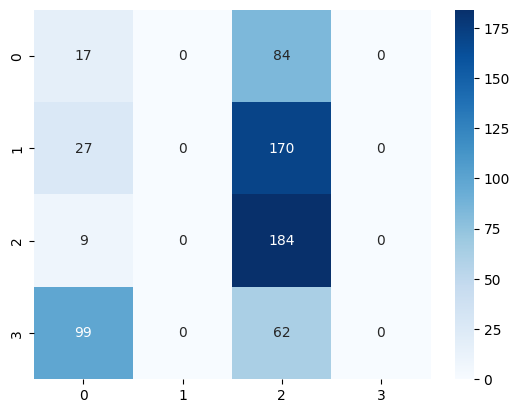

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_mat=confusion_matrix(y_true, y_predict_classes)
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt="d")